Ex 1

1. In the first exercise you will design a simpler variant of LODA. First you
will generate a 2D dataset that follows a standard normal distribution
(500 points) using sklearn.datasets.make blobs.


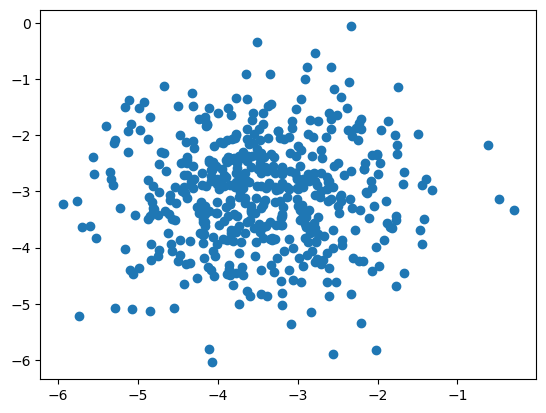

In [1]:
from sklearn.datasets import  make_blobs
import matplotlib.pyplot as plt
from numpy.random import seed

SEED = 232
seed(SEED)

x, y = make_blobs(
    n_samples = 500, 
    random_state = SEED,
    centers = 1
)

plt.scatter(x[:, 0], x[:, 1])
plt.show()

2. Then you will randomly generate 5 unit-length projection vectors (you
can use numpy.random.multivariate normal with (0, 0) mean and
identity matrix as covariance matrix) that will be used to generate 1D
histograms (for the projected values). You will compute the corresponding histograms with equal-width bins using numpy.histogram (for the
range parameter use a larger interval than the range of the projected values). For each histogram compute the probability corresponding to each
bin and use them to compute the anomaly score of a sample as the mean
of the probabilities (corresponding to each histogram).

In [2]:
from numpy.random import  multivariate_normal
from numpy import  identity
from numpy import  histogram
from numpy.linalg import  norm
from numpy import array
from numpy import sqrt
from numpy import append
from numpy import empty

out = multivariate_normal(
    mean = [0, 0, 0, 0, 0],
    cov = identity(5),
    size = 2
)

print(out)

normalized_out = empty((0,2))
for i in range(out.shape[1]):
    values = out[:,i] / sqrt((out[0, i])**2 + (out[1, i])**2)
    normalized_out = append(normalized_out, [out[:,i] / sqrt((out[0, i])**2 + (out[1, i])**2)], axis = 0)

print(normalized_out)

[[-1.16685593 -1.31126998  0.40004961 -0.93275005 -1.11941571]
 [-0.98206148  0.20921129  1.15900858  0.13117689 -0.75931776]]
[[-0.76509016 -0.64392317]
 [-0.98751008  0.15755585]
 [ 0.32627602  0.94527454]
 [-0.99025527  0.13926411]
 [-0.82757392 -0.56135676]]


In [3]:
from numpy import dot
from numpy import newaxis

projections = []
for vector in normalized_out:
    projection = dot(x, vector)[:, newaxis]
    projections.append(projection)
projections = array(projections)


In [4]:
from numpy import mean
hists = []
for i in range(5):
    hist, _ = histogram(projections[i,:], range = (-5, 5))
    hists.append(hist)

hists = array(hists)
prob_hists = hists / 500
anomaly_score = mean(prob_hists, axis=1)
print(anomaly_score)

[0.0664 0.0988 0.0854 0.0986 0.0678]


3. For testing, generate a dataset with 500 points from a uniform distribution (between -3 and 3 using np.random.uniform). Plot the points in the
test dataset using a colormap (related to the anomaly scores).

Ex 2

1. In this exercise we will try to see how the standard Isolation Forest algorithm introduces some artifacts when computing the anomaly scores.
You will generate 2 clusters of 2-dimensional data using make blobs() function. The 2 clusters will have (10, 0) and (0, 10) as centers, 1 as
standard deviation and 500 samples each.

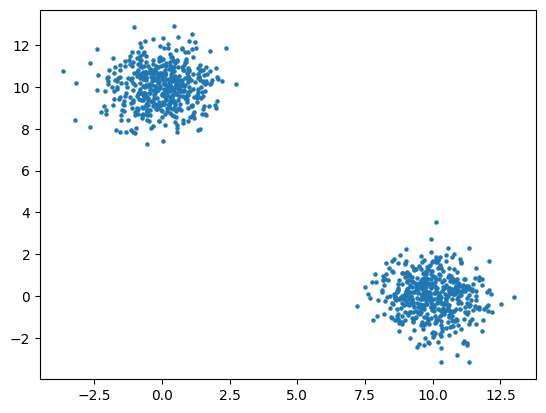

In [63]:
x, y = make_blobs(
    n_samples = (500, 500),
    n_features = 2,
    centers = [(10, 0), (0, 10)]
)

plt.scatter(x[:, 0], x[:, 1], s = 5)
plt.show()

2. You will fit an IForest model (from pyod.models.iforest) using this data (and a contamination rate of 0.02). Test data will be generated from
a uniform distribution over the interval (-10, 20) using np.random.uniform and will contain 1000 samples.

In [64]:
from pyod.models.iforest import IForest

test_x = uniform(
    low = -10, 
    high = 20, 
    size = (1000, 2)
)

model = IForest(
    contamination = 0.02,
    random_state = SEED
)

model.fit(x)


IForest(behaviour='old', bootstrap=False, contamination=0.02,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=232, verbose=0)

3. Find the anomaly scores for the test data and plot the samples using a colormap (related to the anomaly scores). Observe the artefacts introduced by the axis-parallel separating hyperplanes used by standard IForest.

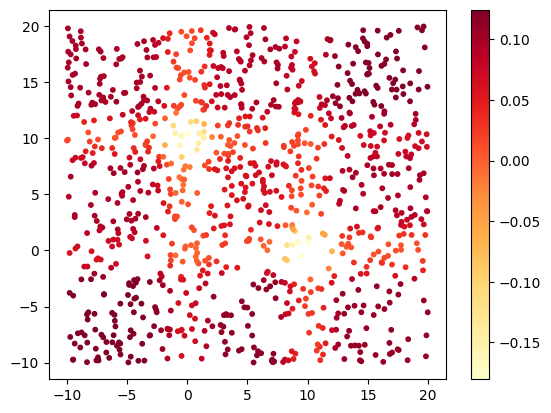

In [65]:
import matplotlib.pyplot as plt

# Calculate anomaly scores for the test data
anomaly_scores = model.decision_function(test_x)

# Create the scatter plot
plt.figure()
scatter = plt.scatter(test_x[:, 0], test_x[:, 1], 
                     c=anomaly_scores, 
                     cmap='YlOrRd', 
                     s=10)
plt.colorbar(scatter)
plt.show()

4. Repeat the same procedure for Deep Isolation Forest model (DIF from pyod.models.dif) and LODA (from pyod.models.loda) and use 3 subplots for the 3 figures.

In [66]:
from pyod.models.dif import DIF
from pyod.models.loda import LODA

test_x = uniform(
    low = -10, 
    high = 20, 
    size = (1000, 2)
)

model_if = IForest(
    contamination = 0.02,
    random_state = SEED
)

model_dif = DIF(
    contamination = 0.02,
    random_state = SEED
)

model_loda = LODA(
    contamination = 0.02,
)

model_if.fit(x)
model_dif.fit(x)
model_loda.fit(x)

LODA(contamination=0.02, n_bins=10, n_random_cuts=100)

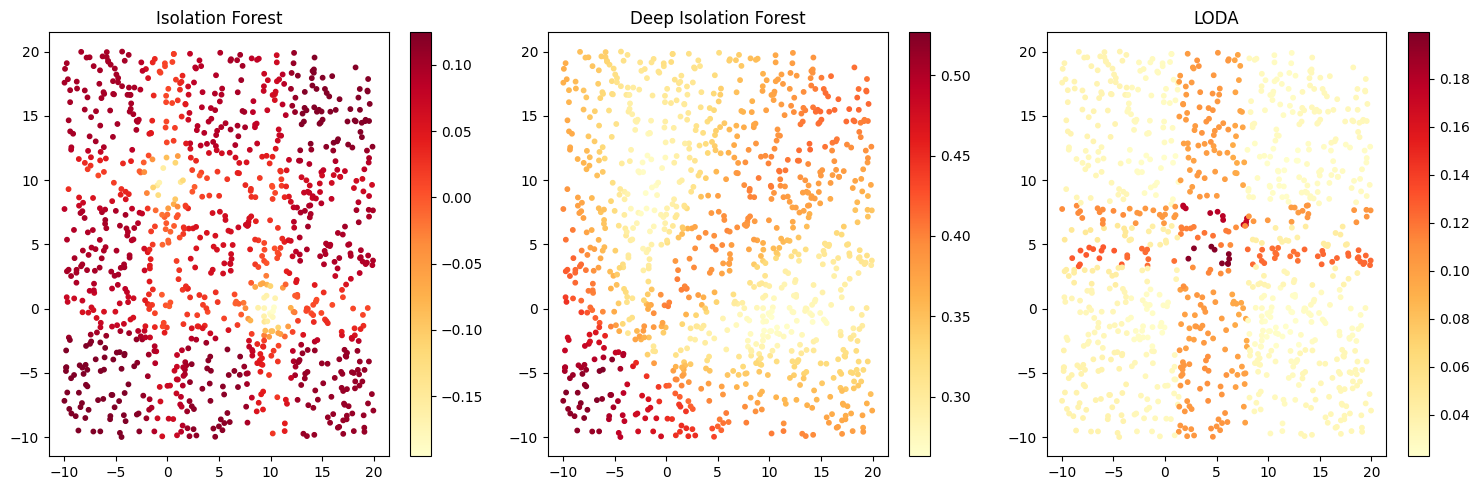

In [67]:
scores_if = model_if.decision_function(test_x)
scores_dif = model_dif.decision_function(test_x)
scores_loda = model_loda.decision_function(test_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

scatter1 = ax1.scatter(test_x[:, 0], test_x[:, 1], 
                      c=scores_if, 
                      cmap='YlOrRd', 
                      s=10)
ax1.set_title('Isolation Forest')
plt.colorbar(scatter1, ax=ax1)

scatter2 = ax2.scatter(test_x[:, 0], test_x[:, 1], 
                      c=scores_dif, 
                      cmap='YlOrRd', 
                      s=10)
ax2.set_title('Deep Isolation Forest')
plt.colorbar(scatter2, ax=ax2)

scatter3 = ax3.scatter(test_x[:, 0], test_x[:, 1], 
                      c=scores_loda, 
                      cmap='YlOrRd', 
                      s=10)
ax3.set_title('LODA')
plt.colorbar(scatter3, ax=ax3)

plt.tight_layout()
plt.show()

5. Try different number of neurons for the hidden layers used by DIF and different number of bins for LODA. Try to explain why the score maps for LODA look that way.


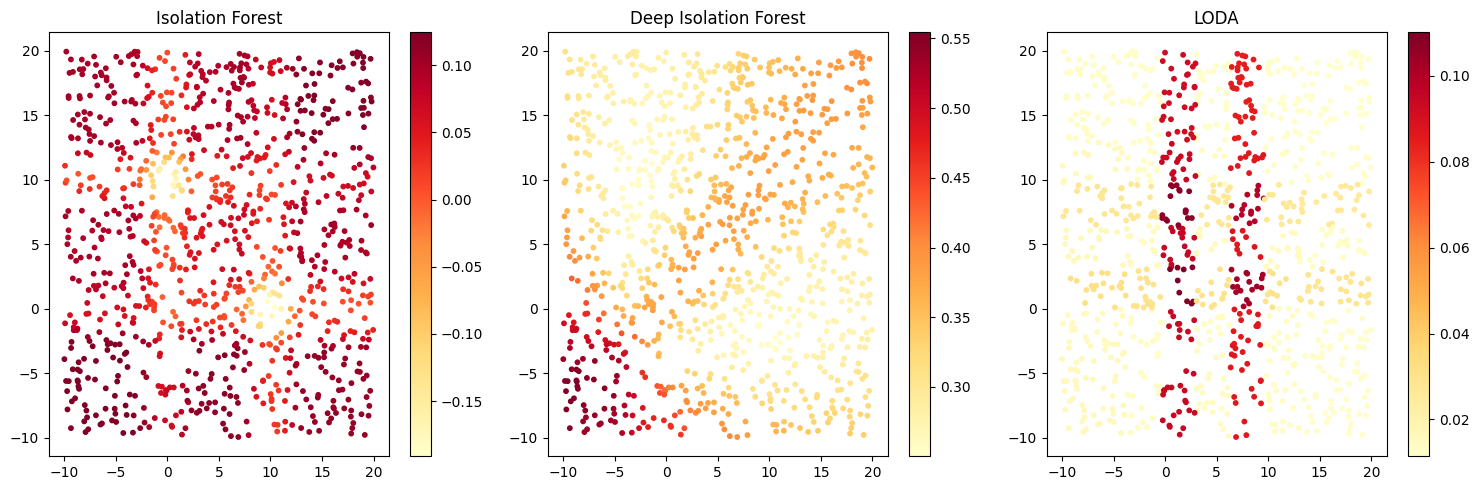

In [68]:
from pyod.models.dif import DIF
from pyod.models.loda import LODA

test_x = uniform(
    low = -10, 
    high = 20, 
    size = (1000, 2)
)

model_if = IForest(
    contamination = 0.02,
    random_state = SEED
)

model_dif = DIF(
    contamination = 0.02,
    random_state = SEED,
    hidden_neurons = [16, 8]
)

model_loda = LODA(
    contamination = 0.02,
    n_bins = 5
)

model_if.fit(x)
model_dif.fit(x)
model_loda.fit(x)

scores_if = model_if.decision_function(test_x)
scores_dif = model_dif.decision_function(test_x)
scores_loda = model_loda.decision_function(test_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

scatter1 = ax1.scatter(test_x[:, 0], test_x[:, 1], 
                      c=scores_if, 
                      cmap='YlOrRd', 
                      s=10)
ax1.set_title('Isolation Forest')
plt.colorbar(scatter1, ax=ax1)

scatter2 = ax2.scatter(test_x[:, 0], test_x[:, 1], 
                      c=scores_dif, 
                      cmap='YlOrRd', 
                      s=10)
ax2.set_title('Deep Isolation Forest')
plt.colorbar(scatter2, ax=ax2)

scatter3 = ax3.scatter(test_x[:, 0], test_x[:, 1], 
                      c=scores_loda, 
                      cmap='YlOrRd', 
                      s=10)
ax3.set_title('LODA')
plt.colorbar(scatter3, ax=ax3)

plt.tight_layout()
plt.show()

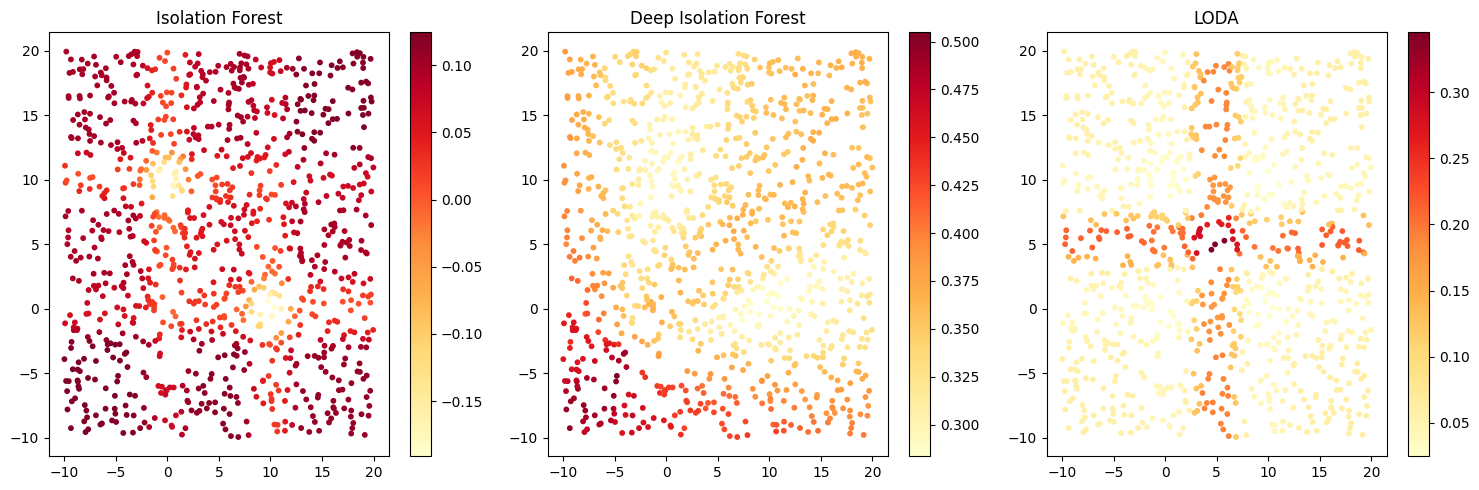

In [69]:
from pyod.models.dif import DIF
from pyod.models.loda import LODA

test_x = uniform(
    low = -10, 
    high = 20, 
    size = (1000, 2)
)

model_if = IForest(
    contamination = 0.02,
    random_state = SEED
)

model_dif = DIF(
    contamination = 0.02,
    random_state = SEED,
    hidden_neurons = [64, 32, 16, 8]
)

model_loda = LODA(
    contamination = 0.02,
    n_bins = 30
)

model_if.fit(x)
model_dif.fit(x)
model_loda.fit(x)

scores_if = model_if.decision_function(test_x)
scores_dif = model_dif.decision_function(test_x)
scores_loda = model_loda.decision_function(test_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

scatter1 = ax1.scatter(test_x[:, 0], test_x[:, 1], 
                      c=scores_if, 
                      cmap='YlOrRd', 
                      s=10)
ax1.set_title('Isolation Forest')
plt.colorbar(scatter1, ax=ax1)

scatter2 = ax2.scatter(test_x[:, 0], test_x[:, 1], 
                      c=scores_dif, 
                      cmap='YlOrRd', 
                      s=10)
ax2.set_title('Deep Isolation Forest')
plt.colorbar(scatter2, ax=ax2)

scatter3 = ax3.scatter(test_x[:, 0], test_x[:, 1], 
                      c=scores_loda, 
                      cmap='YlOrRd', 
                      s=10)
ax3.set_title('LODA')
plt.colorbar(scatter3, ax=ax3)

plt.tight_layout()
plt.show()

Conclusion: It looks like LODA with more bins results in smoother transitions

6. Redo all the steps in 3D (use (0, 10, 0) and (10, 0 , 10) as centers for the two clusters).


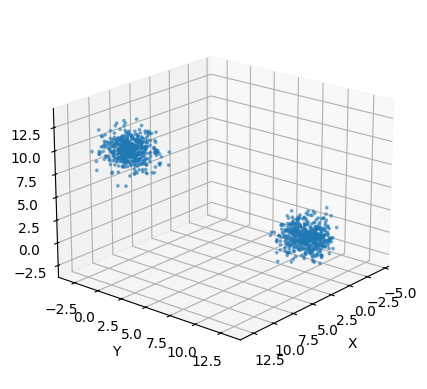

In [70]:
from mpl_toolkits.mplot3d import Axes3D  

x, y = make_blobs(
    n_samples=(500, 500),
    n_features=3,
    centers=[(0, 10, 0), (10, 0, 10)]
)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:, 0], x[:, 1], x[:, 2], s=3, alpha = 0.5)
ax.view_init(elev=20, azim=40) 

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

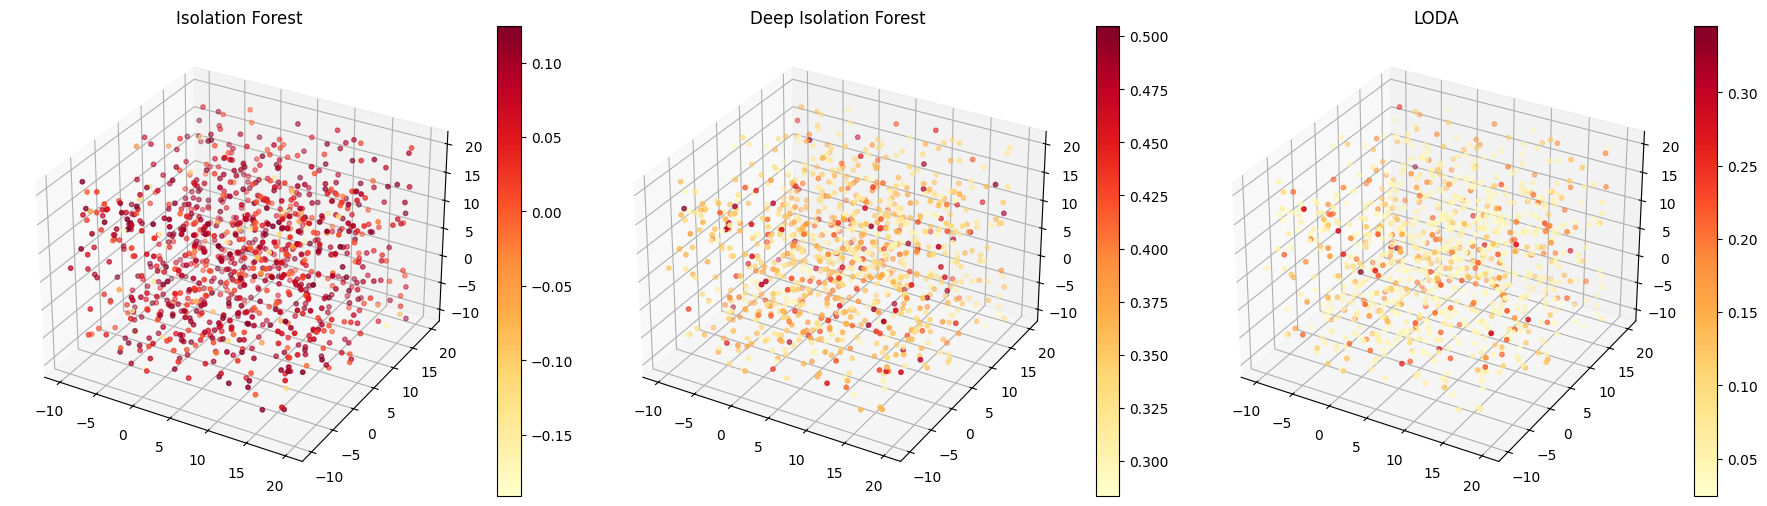

In [79]:
from pyod.models.dif import DIF
from pyod.models.loda import LODA

test_x = uniform(
    low = -10, 
    high = 20, 
    size = (1000, 3)
)

model_if = IForest(
    contamination = 0.02,
    random_state = SEED
)

model_dif = DIF(
    contamination = 0.02,
    random_state = SEED,
)

model_loda = LODA(
    contamination = 0.02,
)

model_if.fit(x)
model_dif.fit(x)
model_loda.fit(x)

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(test_x[:, 0], test_x[:, 1], test_x[:, 2], 
                       c=scores_if, cmap='YlOrRd', s=10)
ax1.set_title('Isolation Forest')
fig.colorbar(scatter1, ax=ax1)

# Deep Isolation Forest 3D plot
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(test_x[:, 0], test_x[:, 1], test_x[:, 2], 
                       c=scores_dif, cmap='YlOrRd', s=10)
ax2.set_title('Deep Isolation Forest')
fig.colorbar(scatter2, ax=ax2)

# LODA 3D plot
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(test_x[:, 0], test_x[:, 1], test_x[:, 2], 
                       c=scores_loda, cmap='YlOrRd', s=10)
ax3.set_title('LODA')
fig.colorbar(scatter3, ax=ax3) 

plt.tight_layout()
plt.show()

Ex 3


1. For this exercise we will need the shuttle dataset from ODDS (https://odds.cs.stonybrook.edu/shuttle-dataset/). Load the data using scipy.io.loadmat() and use train test split() to split it into train and test subsets (use 40% of data for testing). Normalize your data accordingly.


In [ ]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = loadmat("shuttle.mat")
X = data['X'] 
y = data['y'].ravel() 

x_train, x_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.40, 
    random_state=42  
)

scaler = StandardScaler()

scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

Training set shape: (29458, 9)
Test set shape: (19639, 9)
Training labels shape: (29458,)
Test labels shape: (19639,)


2. Fit IForest, LODA and DIF using the training data and compute the balanced accuracy (BA) and the area under the curve (ROC AUC - using sklearn.metrics.roc auc score) for each model. Compute the mean BA and ROC AUC obtained for 10 different train-test splits for each of the models.


In [56]:
from scipy.io import loadmat
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from pyod.models.iforest import IForest
from pyod.models.loda import LODA
from pyod.models.dif import DIF

n_splits = 10

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=i)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    iforest = IForest()
    iforest.fit(X_train_scaled)
    iforest_pred = iforest.predict(X_test_scaled)
    iforest_scores = iforest.decision_function(X_test_scaled)
    
    loda = LODA()
    loda.fit(X_train_scaled)
    loda_pred = loda.predict(X_test_scaled)
    loda_scores = loda.decision_function(X_test_scaled)
    
    dif = DIF()
    dif.fit(X_train_scaled)
    dif_pred = dif.predict(X_test_scaled)
    dif_scores = dif.decision_function(X_test_scaled)
    
    print(f"\nSplit {i+1}:")
    
    ba = balanced_accuracy_score(y_test, iforest_pred)
    auc = roc_auc_score(y_test, iforest_scores)
    print(f"IForest - BA: {ba:.3f}, AUC: {auc:.3f}")
    
    ba = balanced_accuracy_score(y_test, loda_pred)
    auc = roc_auc_score(y_test, loda_scores)
    print(f"LODA    - BA: {ba:.3f}, AUC: {auc:.3f}")
    
    ba = balanced_accuracy_score(y_test, dif_pred)
    auc = roc_auc_score(y_test, dif_scores)
    print(f"DIF     - BA: {ba:.3f}, AUC: {auc:.3f}")



Split 1:
IForest - BA: 0.975, AUC: 0.997
LODA    - BA: 0.741, AUC: 0.874
DIF     - BA: 0.511, AUC: 0.969

Split 2:
IForest - BA: 0.977, AUC: 0.997
LODA    - BA: 0.750, AUC: 0.918
DIF     - BA: 0.523, AUC: 0.975

Split 3:
IForest - BA: 0.977, AUC: 0.997
LODA    - BA: 0.454, AUC: 0.625
DIF     - BA: 0.524, AUC: 0.970

Split 4:
IForest - BA: 0.977, AUC: 0.997
LODA    - BA: 0.693, AUC: 0.770
DIF     - BA: 0.517, AUC: 0.959

Split 5:
IForest - BA: 0.978, AUC: 0.997
LODA    - BA: 0.470, AUC: 0.044
DIF     - BA: 0.528, AUC: 0.972

Split 6:
IForest - BA: 0.976, AUC: 0.996
LODA    - BA: 0.920, AUC: 0.969
DIF     - BA: 0.518, AUC: 0.953

Split 7:
IForest - BA: 0.975, AUC: 0.997
LODA    - BA: 0.643, AUC: 0.630
DIF     - BA: 0.509, AUC: 0.972

Split 8:
IForest - BA: 0.976, AUC: 0.996
LODA    - BA: 0.595, AUC: 0.468
DIF     - BA: 0.514, AUC: 0.970

Split 9:
IForest - BA: 0.978, AUC: 0.997
LODA    - BA: 0.917, AUC: 0.971
DIF     - BA: 0.524, AUC: 0.976

Split 10:
IForest - BA: 0.980, AUC: 0.997
LOD